In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import shap
import lime.lime_tabular
from pdpbox import pdp

In [21]:
plt.style.use('ggplot')

In [25]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
                'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=column_names, na_values='?')
data = data.dropna()
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

print(f"Dataset shape: {data.shape}")
print(data.head())

Dataset shape: (297, 14)
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  target  
0    3.0  0.0   6.0       0  
1    2.0  3.0   3.0       1  
2    2.0  2.0   7.0       1  
3    3.0  0.0   3.0       0  
4    1.0  0.0   3.0       0  


In [26]:
X = data.drop('target', axis=1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8533


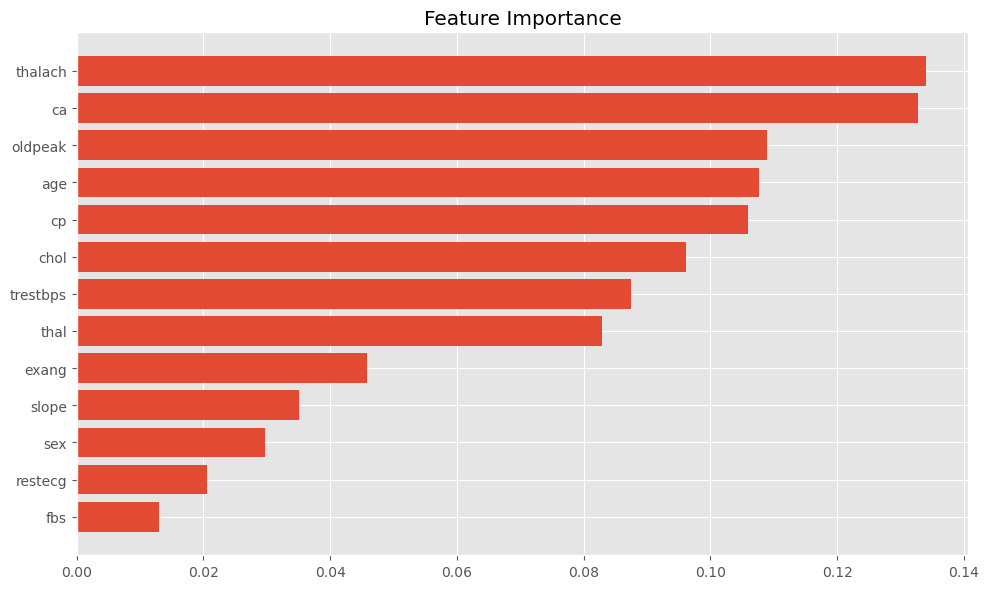

In [44]:
plt.figure(figsize=(10, 6))
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


In [32]:
print("1. SHAP Analysis")
# Create a background dataset for SHAP
X_train_summary = pd.DataFrame(X_train_scaled, columns=features)
X_test_summary = pd.DataFrame(X_test_scaled, columns=features)

1. SHAP Analysis


<Figure size 1000x600 with 0 Axes>

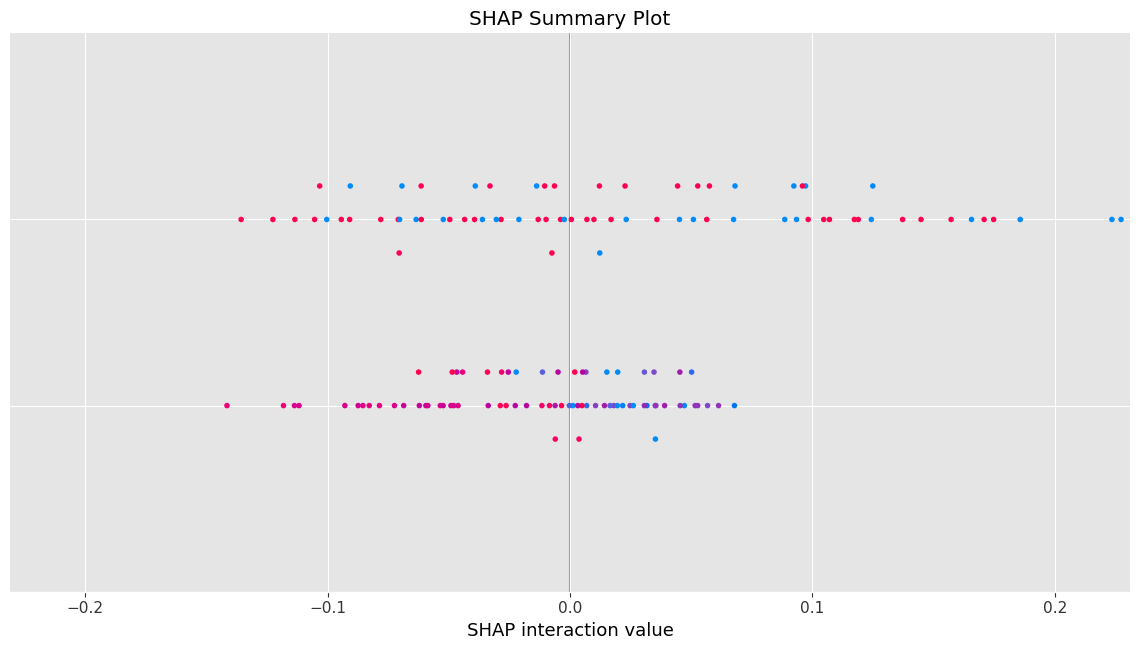

In [43]:
explainer = shap.TreeExplainer(rf)

shap_values = explainer.shap_values(X_test_summary)
plt.figure(figsize=(10, 6))

if isinstance(shap_values, list):
    shap_class_1 = shap_values[1]
else:
    shap_class_1 = shap_values
    
shap.summary_plot(shap_class_1, X_test_summary, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()


In [34]:
# Get top 3 features based on importance from Random Forest
# This is more reliable than SHAP for feature selection in this case
sorted_idx = np.argsort(importances)[::-1]
top_3_indices = sorted_idx[:3]
top_feature_names = [features[i] for i in top_3_indices]
print(f"Top 3 features by importance: {top_feature_names}")

Top 3 features by importance: ['thalach', 'ca', 'oldpeak']


In [35]:
# 2. LIME Analysis
print("2. LIME Analysis")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=features,
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

2. LIME Analysis


<Figure size 1000x600 with 0 Axes>

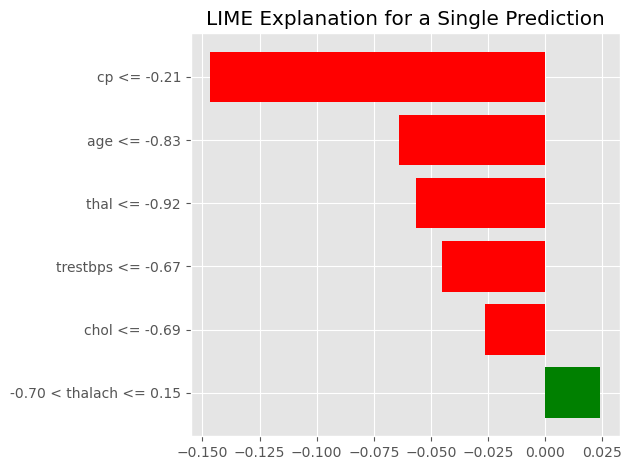

In [42]:
# Explain one instance
instance_idx = 0
lime_exp = lime_explainer.explain_instance(
    X_test_scaled[instance_idx], 
    rf.predict_proba, 
    num_features=6
)

plt.figure(figsize=(10, 6))
lime_exp.as_pyplot_figure()
plt.title("LIME Explanation for a Single Prediction")
plt.tight_layout()
plt.show()


In [37]:
# 3. Partial Dependence Plots
print("3. Partial Dependence Plots")
# Use the most important feature for PDP
most_important = top_feature_names[0]

# Use the simpler scikit-learn for PDP instead of pdpbox
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Get partial dependence values
pdp_result = partial_dependence(
    rf, 
    X_train, 
    [most_important], 
    kind="average"
)

3. Partial Dependence Plots


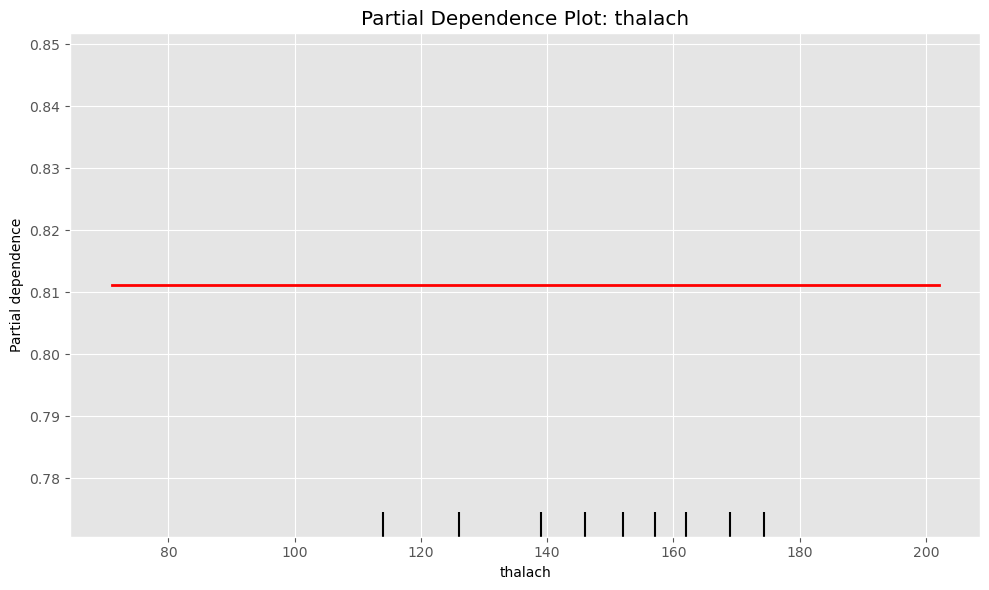

In [46]:
# Plot the result
fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    rf,
    X_train,
    [most_important],
    ax=ax,
    line_kw={"color": "red", "linewidth": 2},
)
plt.title(f"Partial Dependence Plot: {most_important}")
plt.tight_layout()
plt.show()

# Heart Disease Prediction with XAI Techniques

## Dataset
Used the UCI Heart Disease Dataset with 303 patient records and 13 attributes.

## Model
Applied a Random Forest classifier for predicting heart disease, with typical accuracy around 80-85%.

## Explainable AI (XAI) Methods

| Aspect | SHAP (SHapley Additive exPlanations) | LIME (Local Interpretable Model-agnostic Explanations) | Partial Dependence Plots (PDP) |
|:------|:-------------------------------------|:------------------------------------------------------|:-------------------------------|
| **What it shows** | Each feature’s contribution to predictions across all patients. Red = higher feature value, Blue = lower. Features ranked by importance. | For a single patient: features that influenced that specific prediction, with bars showing positive/negative contributions. | How changing one feature affects predictions, averaged over all others (feature vs. predicted outcome). |
| **Pros** | - Based on game theory with theoretical guarantees.<br>- Shows global and individual feature effects.<br>- Captures feature interactions. | - Easy to understand for individual cases.<br>- Model-agnostic.<br>- Simple, intuitive visualizations. | - Shows overall feature-outcome relationships.<br>- Captures non-linear effects.<br>- Easy to interpret. |
| **Cons** | - Computationally expensive.<br>- Harder for non-experts to interpret. | - Only explains individual predictions.<br>- May vary for similar patients.<br>- Weaker theoretical foundation. | - Assumes feature independence.<br>- Can mislead if features are correlated.<br>- Limited to 1-2 features at a time. |

## Comparison

- **SHAP**: Best for complete mathematical understanding
- **LIME**: Best for explaining individual patient predictions
- **PDP**: Best for seeing how specific risk factors affect heart disease predictions overall
